### Integrantes:
- Giovanni Ahumada
- Matías Díaz
- Daniel Saavedra

### Descripción del laboratorio:
Se exploran datasets de uso libre que tienen la información de:
- Egresados de enseñanza media (años 2015 a 2020)
- Titulados en educación superior (año 2022)

Lo que se quiere conseguir con los datasets, seria clasificar cual podría ser lo máximo que un estudiante podría aspirar en términos de grado/título conseguir al egresar en educación superior, los posibles resultados son:
- Carreras Profesionales
- Carreras Técnicas
- Postítulo
- Magister
- Doctorado

## Importaciones y carga de archivos

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import( accuracy_score, classification_report, confusion_matrix,
                            precision_score, recall_score, f1_score)

from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import gc
from sklearn.utils.class_weight import compute_sample_weight
from imblearn.over_sampling import SMOTENC
import glob

med_ruta = 'Datasets/' 
sup_ruta = 'Datasets/titulados_2022.csv'

egresados_pattern = med_ruta + 'egresados_*.csv'
egresados_files = glob.glob(egresados_pattern)

dfs_egresados = []
    
for file_path in sorted(egresados_files):
    df = pd.read_csv(file_path, sep=';', na_values=['', ' ','nan'])
    dfs_egresados.append(df)
    
# Unificar todos los dataframes
med_df = pd.concat(dfs_egresados, ignore_index=True)
print(f"Total unificado: {len(med_df):,} registros")

del dfs_egresados
gc.collect()

# Cargar dataset de titulados
sup_df = pd.read_csv(sup_ruta, sep=';', na_values=['', ' ','nan'])
print(f"Total titulados: {len(sup_df):,} registros")


Total unificado: 5,559,356 registros
Total titulados: 290,902 registros


## EDA
### Revisión de datos null/na

Se revisó el estado de los dataset para ver si es que existían columnas de ambos datasets, sup_df (datos de titulados de educación superior) y med_df (datos de egresados de enseñanza media), dependiendo de la cantidad de datos nulos que tengan las columnas vistas se decidirá que hacer, si la mayoría es nulo se elimina por completo la columna, si hay datos que si o si no se pueden repetir por lo que representan, solo se eliminarán las filas afectadas para evitar una imputación que podría traer duplicados posteriores.

### Revisión de tipos de valores de las columnas

Se utilizó la función .info() para ver en los dos dataset para ver cuantas columnas númericas y categóricas tiene cada una, así posteriormente se puede trabajar su imputación y escalado una vez se procesen los datos. Además de poder cambiar de tipo de dato a los que sean necesarios, como la columna PROM_NOTA_ALU, que está escrito como categórico a pesar de que sirve mucho más como númerico.

In [66]:
med_df.isnull().sum()

AGNO                    0
RBD                     0
DGV_RBD           5540087
COD_REG_RBD           132
NOM_REG_RBD_A         132
COD_PRO_RBD           132
COD_COM_RBD           132
NOM_COM_RBD           132
COD_DEPROV_RBD        132
NOM_DEPROV_RBD        132
COD_ENSE                0
COD_GRADO               0
COD_DEPE              132
COD_DEPE2             132
RURAL_RBD             132
MRUN                    0
MRUN_IPE          5488272
PROM_NOTAS_ALU          0
ORIGEN                  0
ENSE_COMPLETA           0
MARCA_EGRESO            0
dtype: int64

In [67]:
sup_df.isnull().sum()

cat_periodo                     0
codigo_unico                    0
mrun                          510
gen_alu                         0
fec_nac_alu                     0
rango_edad                      0
anio_ing_carr_ori               0
sem_ing_carr_ori                0
anio_ing_carr_act               0
sem_ing_carr_act                0
nomb_titulo_obtenido        26196
nomb_grado_obtenido        161324
fecha_obtencion_titulo          0
tipo_inst_1                     0
tipo_inst_2                     0
tipo_inst_3                     0
cod_inst                        0
nomb_inst                       0
cod_sede                        0
nomb_sede                       0
cod_carrera                  4036
nomb_carrera                    0
nivel_global                    0
nivel_carrera_1                 0
nivel_carrera_2                 0
dur_estudio_carr                0
dur_proceso_tit                 0
dur_total_carr                  0
region_sede                     0
provincia_sede

In [68]:
med_df = med_df.drop(columns=['DGV_RBD','MRUN_IPE'])
sup_df = sup_df.drop(columns=['nomb_grado_obtenido'])
sup_df = sup_df.dropna(subset=['mrun'])

In [69]:
sup_df.info()
med_df.info()

print(f"Filas duplicadas media {med_df['MRUN'].duplicated().sum()}")
print(f"Filas duplicadas superior {sup_df['mrun'].duplicated().sum()}") 

<class 'pandas.core.frame.DataFrame'>
Index: 290392 entries, 0 to 290391
Data columns (total 40 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   cat_periodo              290392 non-null  int64  
 1   codigo_unico             290392 non-null  object 
 2   mrun                     290392 non-null  float64
 3   gen_alu                  290392 non-null  int64  
 4   fec_nac_alu              290392 non-null  int64  
 5   rango_edad               290392 non-null  object 
 6   anio_ing_carr_ori        290392 non-null  int64  
 7   sem_ing_carr_ori         290392 non-null  int64  
 8   anio_ing_carr_act        290392 non-null  int64  
 9   sem_ing_carr_act         290392 non-null  int64  
 10  nomb_titulo_obtenido     264459 non-null  object 
 11  fecha_obtencion_titulo   290392 non-null  int64  
 12  tipo_inst_1              290392 non-null  object 
 13  tipo_inst_2              290392 non-null  object 
 14  tipo_inst

In [70]:
#Dropean las filas duplicadas
sup_df = sup_df.drop_duplicates()
med_df = med_df.drop_duplicates()

#Reemplazar coma por punto decimal
med_df['PROM_NOTAS_ALU'] = med_df['PROM_NOTAS_ALU'].astype(str).str.replace(',', '.', regex=False)
med_df['PROM_NOTAS_ALU'] = pd.to_numeric(med_df['PROM_NOTAS_ALU'], errors='coerce')

## Fusión de datasets principales
(Continuación de EDA)

### Trabajo con MRUN
Al haber revisado ya los dos datasets, se decide fusionarlos en base a la columna que comparten, el MRUN, este dato es el identificador de cada alumno, el cual tiene que ser único, por lo que se tiene que evitar duplicados del MRUN o filas que estén duplicadas directamente, estas se manejarán de tal manera que se intente dejar un MRUN único para cada fila, en el caso donde no sea un duplicado exacto, se intentará tomar a la fila que tenga un mayor valor en el título.

### Identificar target
Se revisó la documentación que viene con el dataset de titulados de educación superior, así se pudo identificar cual es el valor target para clasificar, se hizo un mapeo para tener valores númericos para poder trabajar más fácil con el dato target dentro del modelo y el proceso.

### Eliminación de columnas
Se eliminaron columnas que se encontraron no útiles una vez se mezclaron los datasets para este trabajo.

### Correlación de características
Usando diagramas y matrices de correlación, se observan las columnas que hay en el dateset, con esta información podemos sacar la información relevantes para hacer ingeniería de características para poder acercarse más al valor target y clasificar en torno a el.

### Promedio de notas
Se hizo un trabajo donde se dejó una sola fila para cada MRUN en el dataset de educación media, al mismo tiempo se hace un filtro donde solo se tenga en cuenta si tiene información de haberse egresado de enseñanza media, ya con eso, los estudiantes que coincidan con estas condiciones, se hace un promedio entre todas las notas que se tienen en el dataset y se actualiza creando med_df_egreso.

In [71]:
mrun_validos = med_df.loc[(med_df['MARCA_EGRESO'] == 1) & (med_df['ENSE_COMPLETA'] == 1), 'MRUN'].unique()

promedios_por_mrun = med_df[med_df['MRUN'].isin(mrun_validos)].groupby('MRUN', as_index=False)['PROM_NOTAS_ALU'].mean()

cols_a_conservar = [col for col in med_df.columns if col != 'PROM_NOTAS_ALU']

df_unico = med_df[med_df['MRUN'].isin(mrun_validos)].drop_duplicates(subset='MRUN')[cols_a_conservar]

med_df = df_unico.merge(promedios_por_mrun, on='MRUN', how='left')
med_df_egreso = med_df.copy()

#Mapeado del valor target
mapping_target = {
        'Carreras Técnicas': 0,
        'Carreras Profesionales': 1, 
        'Postítulo': 2,
        'Magister': 3,
        'Doctorado': 4
    }

sup_df['nivel_carrera_2'] = sup_df['nivel_carrera_2'].map(mapping_target)
sup_df.rename(columns={'mrun': 'MRUN'}, inplace=True)

print(med_df_egreso['MRUN'].duplicated().sum())
print(med_df_egreso.columns.tolist())

0
['AGNO', 'RBD', 'COD_REG_RBD', 'NOM_REG_RBD_A', 'COD_PRO_RBD', 'COD_COM_RBD', 'NOM_COM_RBD', 'COD_DEPROV_RBD', 'NOM_DEPROV_RBD', 'COD_ENSE', 'COD_GRADO', 'COD_DEPE', 'COD_DEPE2', 'RURAL_RBD', 'MRUN', 'ORIGEN', 'ENSE_COMPLETA', 'MARCA_EGRESO', 'PROM_NOTAS_ALU']


In [72]:
col_conservar_sup = ['MRUN','nivel_carrera_2']

sup_df = sup_df[col_conservar_sup]

sup_df = sup_df.loc[sup_df.groupby('MRUN')['nivel_carrera_2'].idxmax()]

med_df = med_df_egreso[~med_df_egreso['MRUN'].isin(sup_df['MRUN'])]

com_df = pd.merge(med_df_egreso, sup_df, on='MRUN', how='inner')

del sup_df ,med_df_egreso

col_eliminar = ['AGNO','COD_GRADO','ENSE_COMPLETA','MARCA_EGRESO','ORIGEN']

com_df = com_df.drop(columns=col_eliminar)
med_df = med_df.drop(columns=col_eliminar+['MRUN'])
com_df.value_counts()

RBD    COD_REG_RBD  NOM_REG_RBD_A  COD_PRO_RBD  COD_COM_RBD  NOM_COM_RBD  COD_DEPROV_RBD  NOM_DEPROV_RBD  COD_ENSE  COD_DEPE  COD_DEPE2  RURAL_RBD  MRUN      PROM_NOTAS_ALU  nivel_carrera_2
40457  10.0         LAGOS          102.0        10201.0      CASTRO       102.0           CHILOÉ          610       3.0       2.0        0.0        24565413  5.400000        0                  1
1      15.0         AYP            151.0        15101.0      ARICA        151.0           ARICA           463       6.0       5.0        0.0        1073085   5.250000        0                  1
                                                                                                                                                    11201394  6.500000        2                  1
                                                                                                          510       6.0       5.0        0.0        2222259   5.050000        0                  1
                              

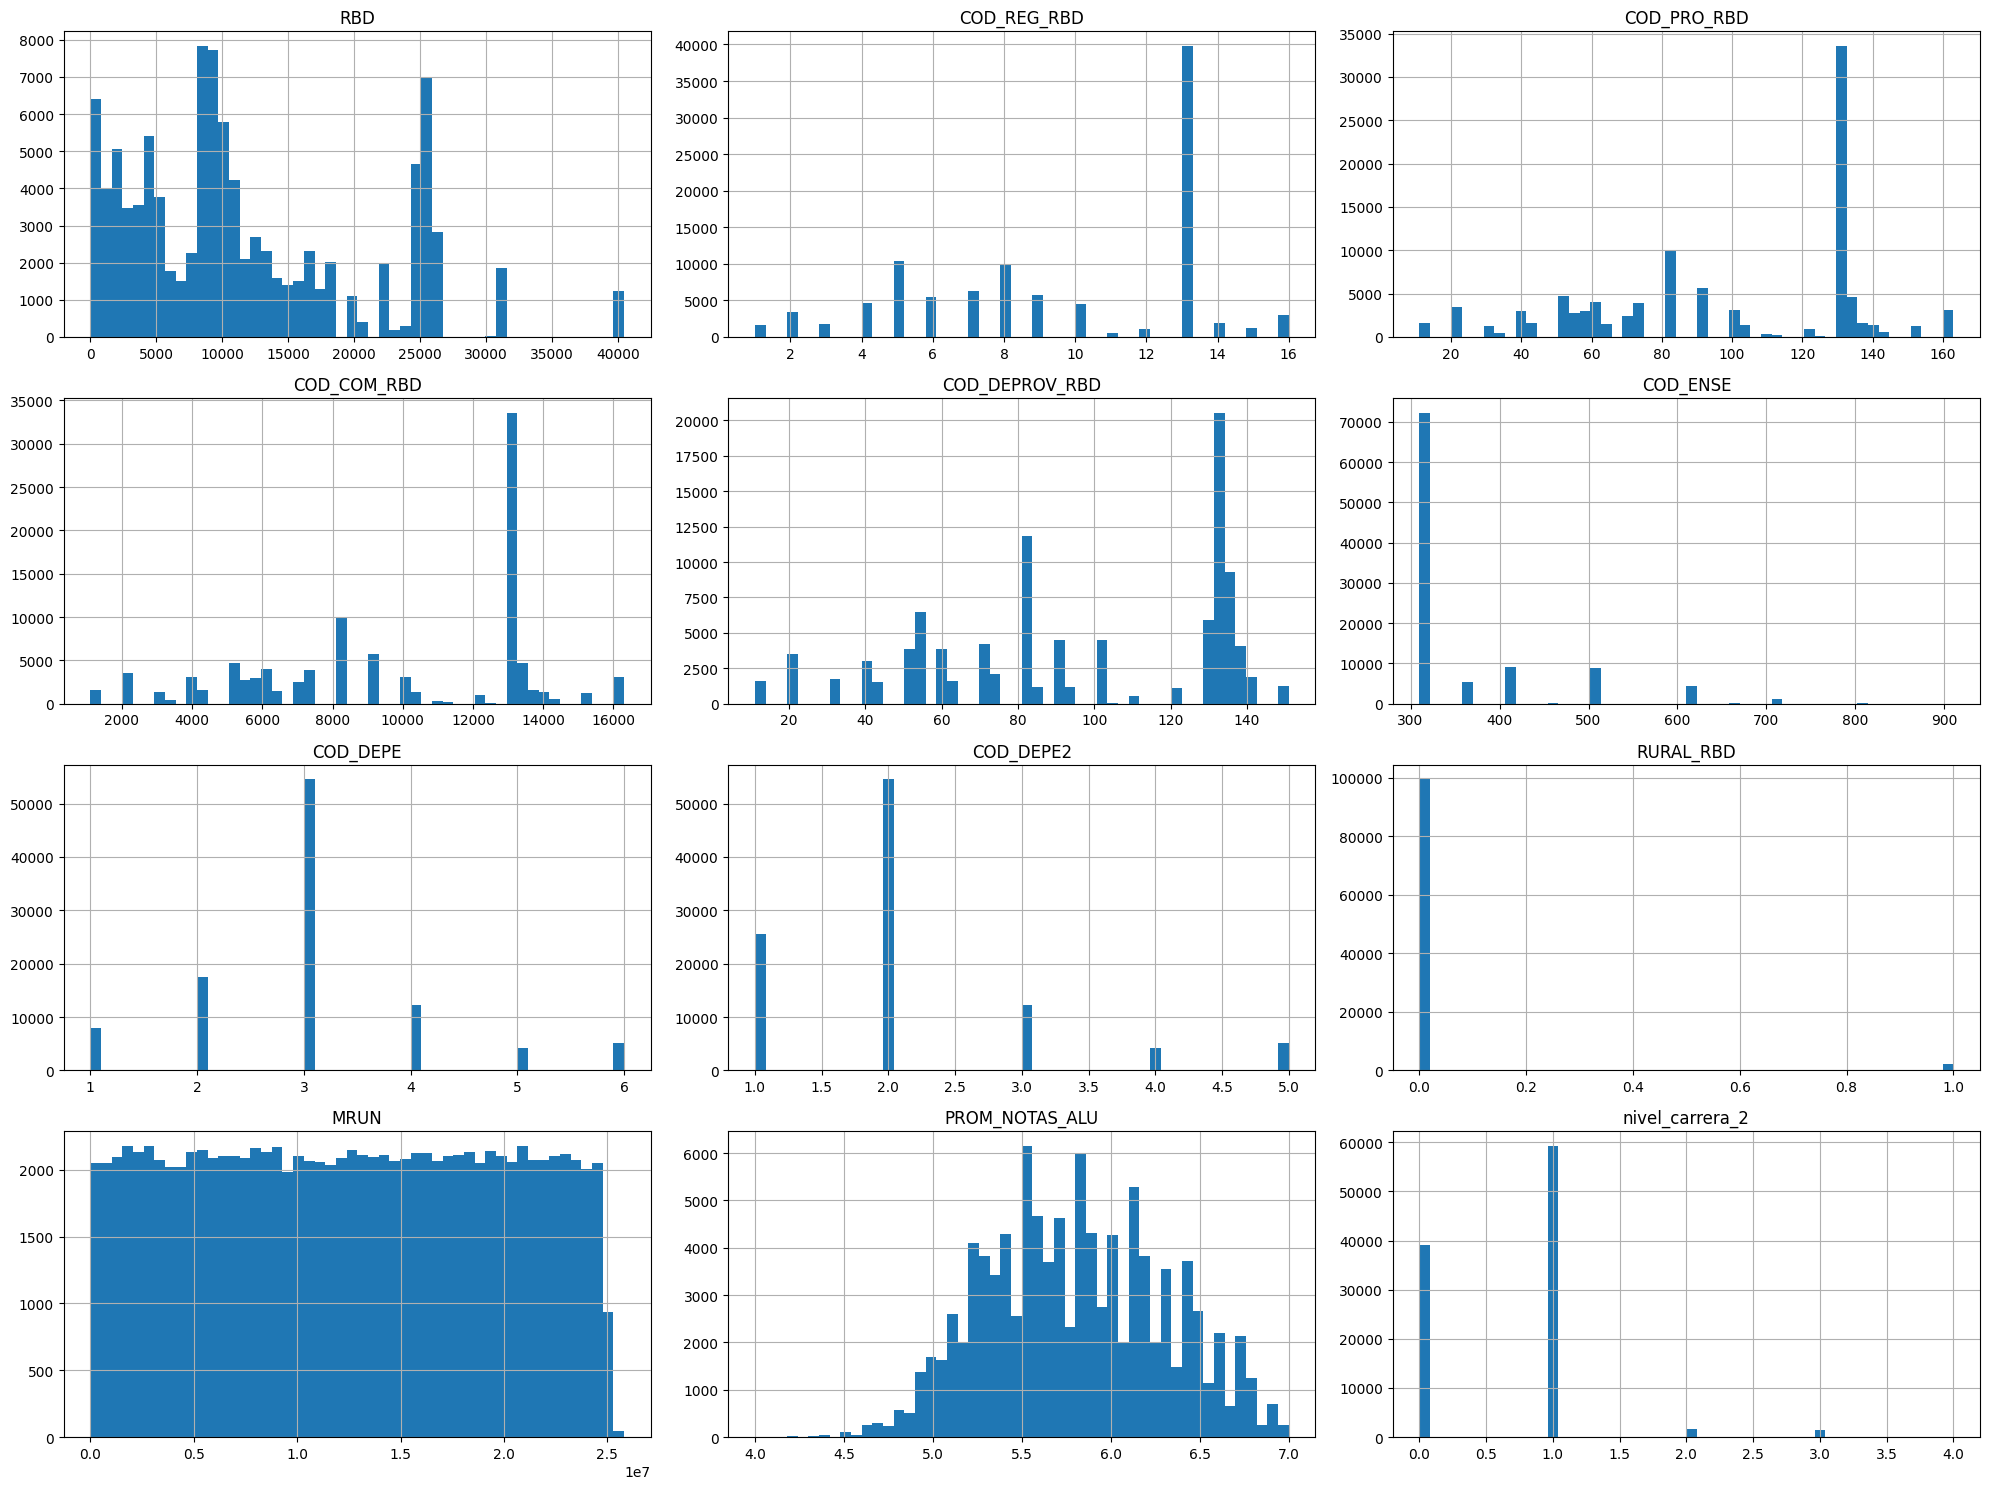

In [73]:
com_df.hist(bins=50, figsize=(20,15))
plt.tight_layout()
plt.show()

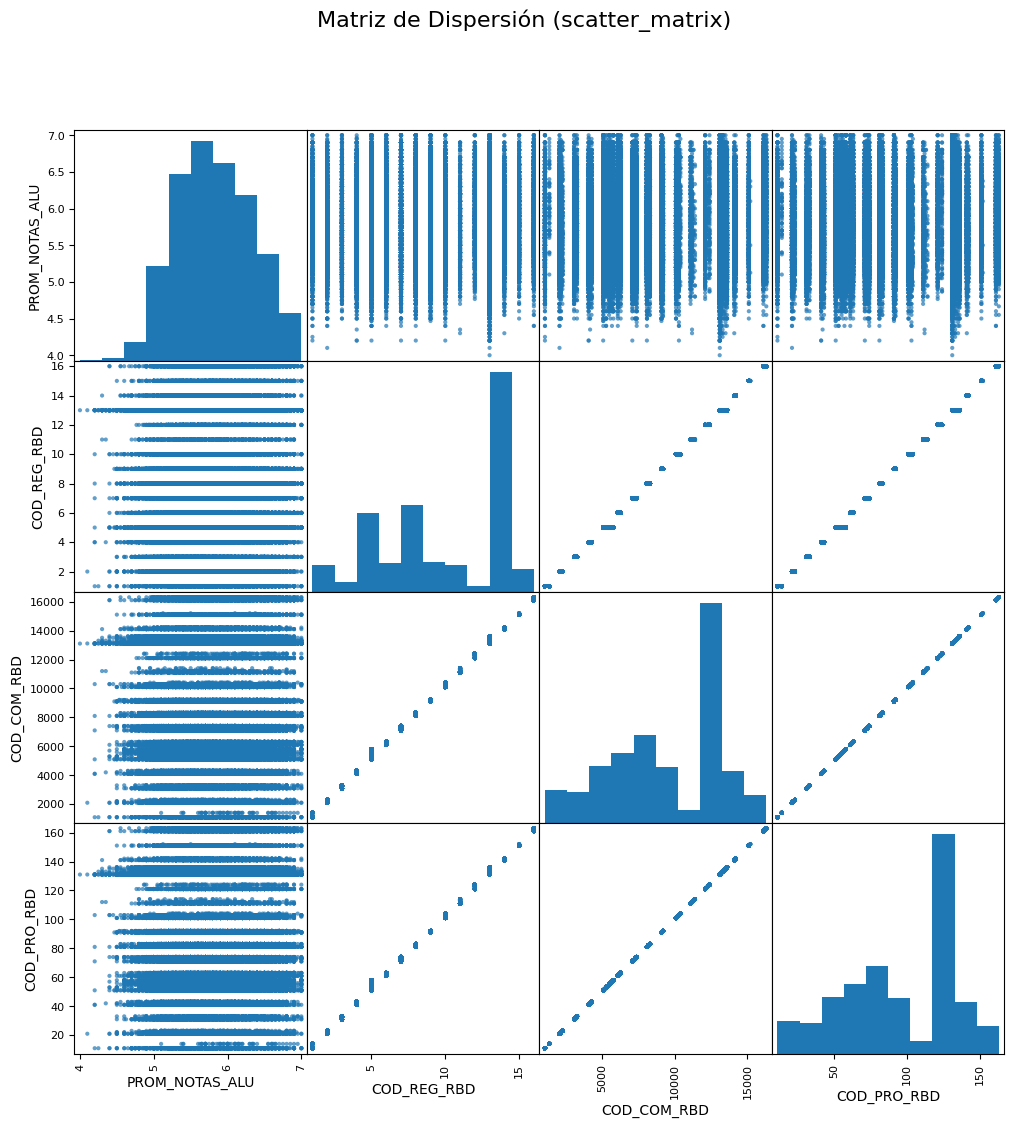

In [74]:
numeric_df = com_df.copy()

numeric_df = numeric_df[['PROM_NOTAS_ALU','COD_REG_RBD','COD_COM_RBD','COD_PRO_RBD']]

scatter_matrix(numeric_df, figsize=(12, 12), diagonal='hist', alpha=0.7)
plt.suptitle("Matriz de Dispersión (scatter_matrix)", fontsize=16)
plt.show()

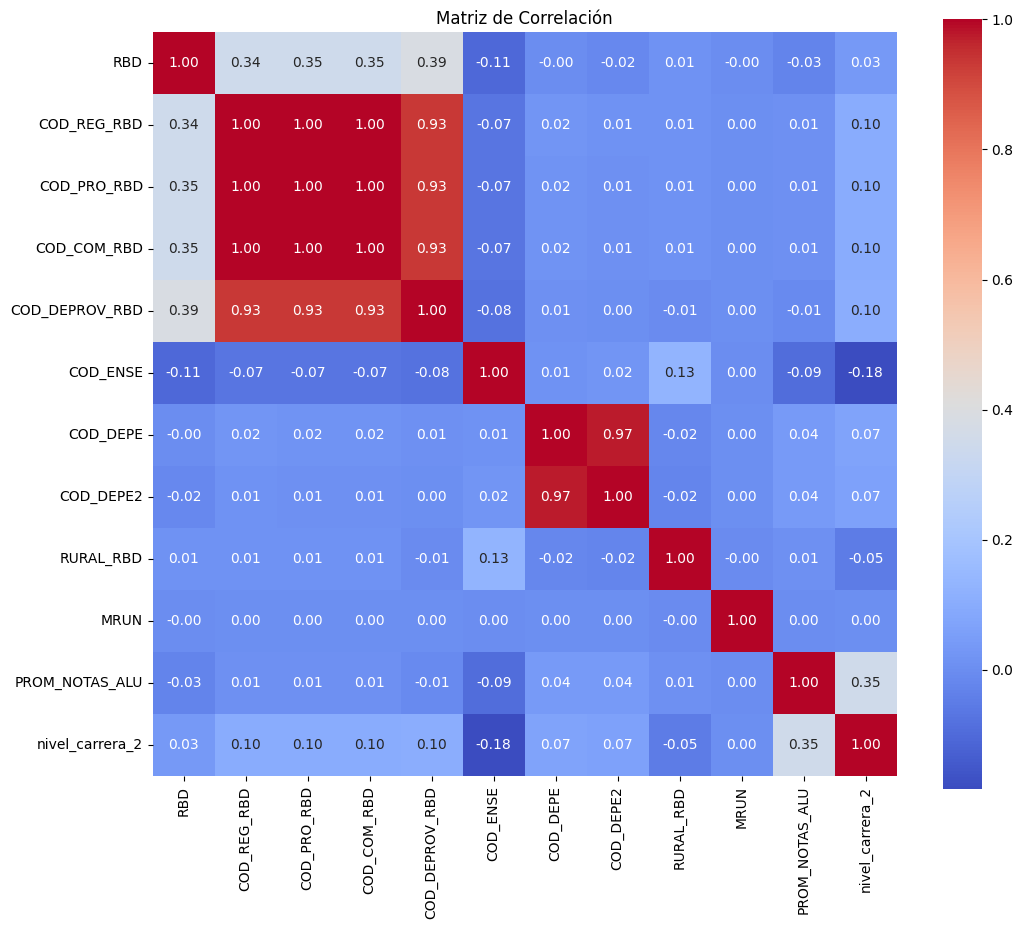

In [75]:
corr_matrix = com_df.corr(numeric_only=True)

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Matriz de Correlación")
plt.show()

In [76]:
#ingeniería de características
def featuresEngineering(df):
    df["NOTAS_X_COD_ENSE"] = df["PROM_NOTAS_ALU"] * df["COD_ENSE"]
    df["NOTAS_DIV_COD_ENSE"] = df["PROM_NOTAS_ALU"] / (df["COD_ENSE"] + 1) 
    return df

com_df = featuresEngineering(com_df)
med_df = featuresEngineering(med_df)

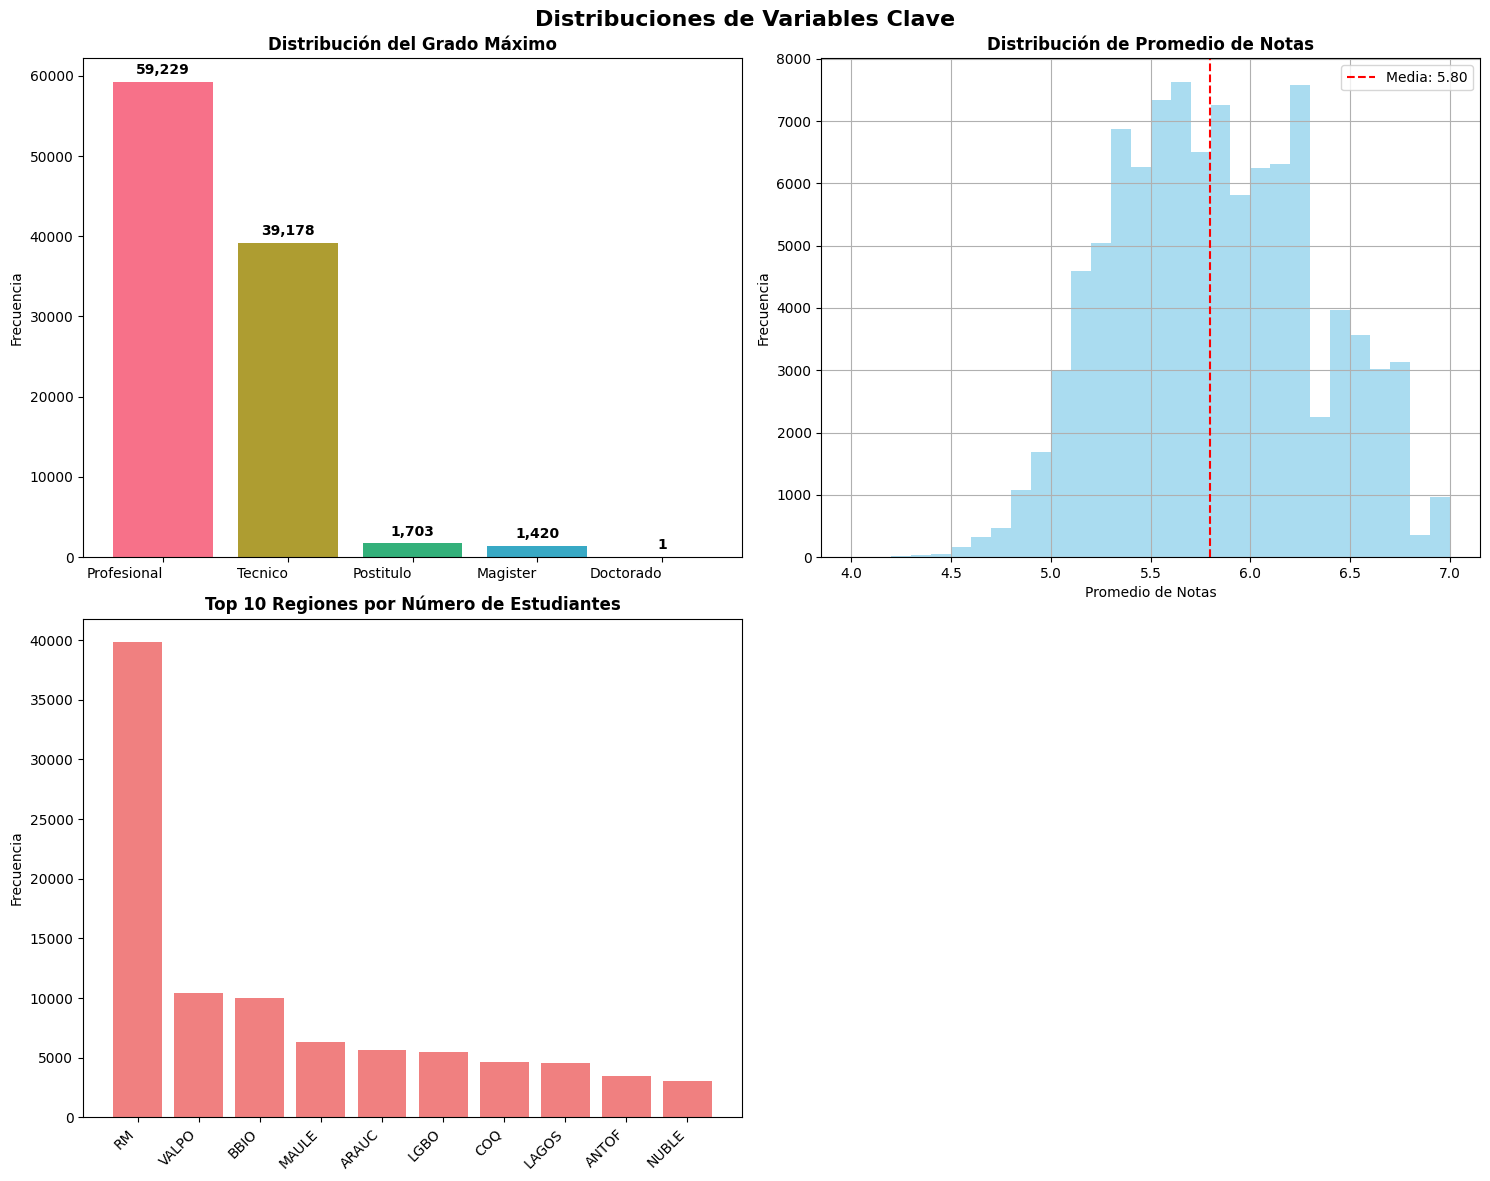

In [77]:
def visualizarDistribucion(df):
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Distribuciones de Variables Clave', fontsize=16, fontweight='bold')
    axes = axes.flatten()

    #Distribución del grado máximo
    ax1 = axes[0]
    target_counts = df['nivel_carrera_2'].value_counts()
    colors = sns.color_palette("husl", len(target_counts))
    bars = ax1.bar(range(len(target_counts)), target_counts.values, color=colors)
    ax1.set_title('Distribución del Grado Máximo', fontweight='bold')
    ax1.set_xticks(range(len(target_counts)))

    labels = ['Profesional','Tecnico','Postitulo','Magister','Doctorado']

    ax1.set_xticklabels(labels, ha='right')
    ax1.set_ylabel('Frecuencia')
    for bar, value in zip(bars, target_counts.values):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(target_counts.values)*0.01,f'{value:,}', ha='center', va='bottom', fontweight='bold')
        
    #Histograma de promedio de notas
    ax2 = axes[1]
    df['PROM_NOTAS_ALU'].hist(bins=30, alpha=0.7, color='skyblue', ax=ax2)
    ax2.set_title('Distribución de Promedio de Notas', fontweight='bold')
    ax2.set_xlabel('Promedio de Notas')
    ax2.set_ylabel('Frecuencia')
    ax2.axvline(df['PROM_NOTAS_ALU'].mean(), color='red', linestyle='--',label=f'Media: {df["PROM_NOTAS_ALU"].mean():.2f}')
    ax2.legend()

    #Distribución por región
    ax3 = axes[2]
    region_counts = df['NOM_REG_RBD_A'].value_counts().head(10)
    bars3 = ax3.bar(range(len(region_counts)), region_counts.values, color='lightcoral')
    ax3.set_title('Top 10 Regiones por Número de Estudiantes', fontweight='bold')
    ax3.set_xticks(range(len(region_counts)))
    ax3.set_xticklabels(region_counts.index, rotation=45, ha='right')
    ax3.set_ylabel('Frecuencia')
    fig.delaxes(axes[3])
    plt.tight_layout()
    plt.show()

visualizarDistribucion(com_df)

## Preparación para aplicar modelos
### Separación de datos
Se hacen dos separación de los datos, para conseguir 3 conjuntos , el cojunto "train" se utiliza para entrenar a los diferentes modelos, "val" se usa para validar el performance de los modelos ya entrenados y "test" se utilizó para ser el test final para comparar por última vez los modelos.

### Pipeline de preprocesamiento
Se creó un pipeline de preprocesamiento para saber como se transformarán las columnas, dependiendo de si son del tipo númericas o categoricas, haciendo imputación para los datos faltantes y "normalizar" los datos.

### Aumento de muestras
Dado que se observó que solo tenemos una muestra de doctorados se decidió tener más, por lo que se creó una función que puede generar más muestras de la clase que se elija y la cantidad deseada, ayudando que doctorado sea una clase que pueda tomarse en cuenta.

In [78]:
features = com_df.drop(columns=['nivel_carrera_2']+['MRUN'])
target = com_df['nivel_carrera_2']

def agregarMasMuestras(features, target, clase_fundamental, n_muestras):
    x, y = features.copy(), target.copy()
    
    if (y == clase_fundamental).sum() == 1:
        fila = x[y == clase_fundamental].copy()
        for col in fila.select_dtypes(include='number').columns:
            fila[col] = fila[col].astype(float) + np.random.normal(0, 0.01)
        x = pd.concat([x, fila], ignore_index=True)
        y = pd.concat([y, y[y == clase_fundamental]], ignore_index=True)

    cat_cols = [col for col in x.columns if x[col].dtype == 'object']
    cat_idx = [x.columns.get_loc(col) for col in cat_cols]

    for col in cat_cols:
        x[col] = pd.Categorical(x[col])
        x[col] = x[col].cat.remove_unused_categories()
        
    smote = SMOTENC(categorical_features=cat_idx,sampling_strategy={clase_fundamental: n_muestras},random_state=42,k_neighbors=1)
    X_res, y_res = smote.fit_resample(x, y)
    return X_res, y_res

features, target = agregarMasMuestras(features,target,4,25)

#Primer split
features_train_val, features_test, target_train_val, target_test = train_test_split(features, target, test_size=0.2, random_state=42,stratify=target)
#Segundo split
features_train, features_val, target_train, target_val = train_test_split(features_train_val, target_train_val, test_size=0.2, random_state=42,stratify=target_train_val)


numeric_features = features.select_dtypes(include='number').columns.tolist()
categorical_features = features.select_dtypes(include='object').columns.tolist()

numeric = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

categorical = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first'))
    ])

preprocessor = ColumnTransformer([
    ('num', numeric, numeric_features),
    ('cat', categorical,categorical_features)
])

print(target_train.value_counts())
print(target_test.value_counts())
print(target_val.value_counts())

nivel_carrera_2
1    37906
0    25074
2     1090
3      909
4       16
Name: count, dtype: int64
nivel_carrera_2
1    11846
0     7836
2      340
3      284
4        5
Name: count, dtype: int64
nivel_carrera_2
1    9477
0    6268
2     273
3     227
4       4
Name: count, dtype: int64


## Entrenamiento de los 3 modelos
### Los modelos que se eligieron para entrenar son:
- DecisionTreeClassifier
- RandomForestClassifier
- XGBClassifier

Se entrenan con el mismo conjunto de entrenamiento cada modelo y aplicando el preprocesamiento que se construyó anteriormente, se prioriza que se balancee lo más que se pueda cada clase para que no solo se tengan en cuenta a los que más muestras tengan, además que se le agrega peso a las muestras, para que la cantidad de muestras por clases no afecte a la clasificación.

In [79]:
def entrenarModelos(x_train, y_train, preprocessor):
    models = {
        'Decision Tree': DecisionTreeClassifier(
            random_state=42,
            class_weight='balanced'
        ),
        'Random Forest': RandomForestClassifier(
            random_state=42,
            n_estimators=50, 
            max_depth=15,
            class_weight='balanced',
            n_jobs=2
        ),
        'XGBoost': XGBClassifier(
            random_state=42,
            n_estimators=100,
            max_depth=6,
            learning_rate=0.1,
            subsample=0.8,
            eval_metric='mlogloss',
            objective='multi:softprob'
        ),
    }
    sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)
    trained_models = {}
    for name, model in models.items():
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', model)
        ])
        pipeline.fit(x_train, y_train, classifier__sample_weight=sample_weights)
        trained_models[name] = pipeline
        gc.collect()
    
    return trained_models

trained_models = entrenarModelos(features_train,target_train,preprocessor)

## Comparación de modelos
Teniendo ya los 3 modelos entrenados, se hará una comparación de los resultados dados entre ellos, así posteriormente se elegirá el que haya dado el mejor de todos.
 
### Se usan las siguientes métricas para evaluar:
- Accuracy
- Precision
- Recall
- F1-Score
- Confusion-Matrix

Se usa una comparación normal de los resultados pudiendose observar al usar el conjunto de validación de manera breve para ver los porcentajes de aciertos usando cada modelo, posteriormente se usó el conjunto test validando con las métricas ya dichas dos maneras de validar los modelos, la normal que usa el conjunto por completo de test y la validación cross, que utiliza diferentes puntos del conjunto de manera cruzada para ver si se usó una generalización buena.

In [80]:
for name, model in trained_models.items():
    val_score = model.score(features_val, target_val)
    print(f"Validation accuracy for {name}: {val_score:.4f}")
    predictions = model.predict(features_val)
    print(f"Classification Report for {name}:\n")
    print(classification_report(target_val, predictions))

Validation accuracy for Decision Tree: 0.6039
Classification Report for Decision Tree:

              precision    recall  f1-score   support

           0       0.57      0.60      0.58      6268
           1       0.68      0.63      0.66      9477
           2       0.03      0.05      0.04       273
           3       0.12      0.22      0.15       227
           4       1.00      1.00      1.00         4

    accuracy                           0.60     16249
   macro avg       0.48      0.50      0.49     16249
weighted avg       0.62      0.60      0.61     16249

Validation accuracy for Random Forest: 0.4254
Classification Report for Random Forest:

              precision    recall  f1-score   support

           0       0.61      0.72      0.66      6268
           1       0.75      0.23      0.35      9477
           2       0.03      0.36      0.05       273
           3       0.06      0.59      0.11       227
           4       1.00      1.00      1.00         4

    accur

In [81]:
def evaluar(models, x_test, y_test):
    results = []
    confusion_matrices = {}

    for name, model in models.items():
        y_pred = model.predict(x_test)

        metrics = {
            'Model': name,
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred, average='weighted', zero_division=0),
            'Recall': recall_score(y_test, y_pred, average='weighted', zero_division=0),
            'F1-Score': f1_score(y_test, y_pred, average='weighted', zero_division=0)
        }
        results.append(metrics)
        confusion_matrices[name] = confusion_matrix(y_test, y_pred)

        del y_pred
        gc.collect()
    
    results_df = pd.DataFrame(results)
    
    print("\nRESUMEN MÉTRICAS EVALUACIÓN NORMAL:\n")
    print(results_df.round(4))
    
    print("\nMATRICES DE CONFUSIÓN:")
    for name, cm in confusion_matrices.items():
        print(f"\n{name}:\n{cm}")

    return results_df

def evaluarCrossVal(models, x_test, y_test, cv=5):
    results = []
    scoring = {
        'accuracy': 'accuracy',
        'precision': 'precision_weighted',
        'recall': 'recall_weighted',
        'f1': 'f1_weighted'
    }

    for name, model in models.items():
        scores = cross_validate(model, x_test, y_test, cv=cv, scoring=scoring, n_jobs=-1)
        metrics = {
            'Model': name,
            'Accuracy': scores['test_accuracy'].mean(),
            'Precision': scores['test_precision'].mean(),
            'Recall': scores['test_recall'].mean(),
            'F1-Score': scores['test_f1'].mean()
        }
        results.append(metrics)
        del scores
    results_df = pd.DataFrame(results)
    print("\nRESUMEN CROSS-VALIDATION:")
    print(results_df.round(4))

    return results_df

results_df = evaluar(trained_models, features_test, target_test)
resultsCross_df = evaluarCrossVal(trained_models,features_test,target_test,cv=5)


RESUMEN MÉTRICAS EVALUACIÓN NORMAL:

           Model  Accuracy  Precision  Recall  F1-Score
0  Decision Tree    0.6092     0.6271  0.6092    0.6170
1  Random Forest    0.4364     0.6790  0.4364    0.4745
2        XGBoost    0.5045     0.6798  0.5045    0.5307

MATRICES DE CONFUSIÓN:

Decision Tree:
[[4802 2924   75   35    0]
 [3454 7496  455  441    0]
 [  65  231   24   20    0]
 [  18  202   16   48    0]
 [   0    1    0    0    4]]

Random Forest:
[[5683  786 1082  285    0]
 [3511 2893 3362 2080    0]
 [  49   93  109   89    0]
 [   7   59   43  175    0]
 [   1    0    0    0    4]]

XGBoost:
[[6191 1066  417  162    0]
 [3850 3769 2328 1899    0]
 [  54   96   92   98    0]
 [  10   48   36  190    0]
 [   1    0    0    0    4]]

RESUMEN CROSS-VALIDATION:
           Model  Accuracy  Precision  Recall  F1-Score
0  Decision Tree    0.6152     0.6203  0.6152    0.6176
1  Random Forest    0.6595     0.6689  0.6595    0.6629
2        XGBoost    0.7165     0.6953  0.7165    0.703

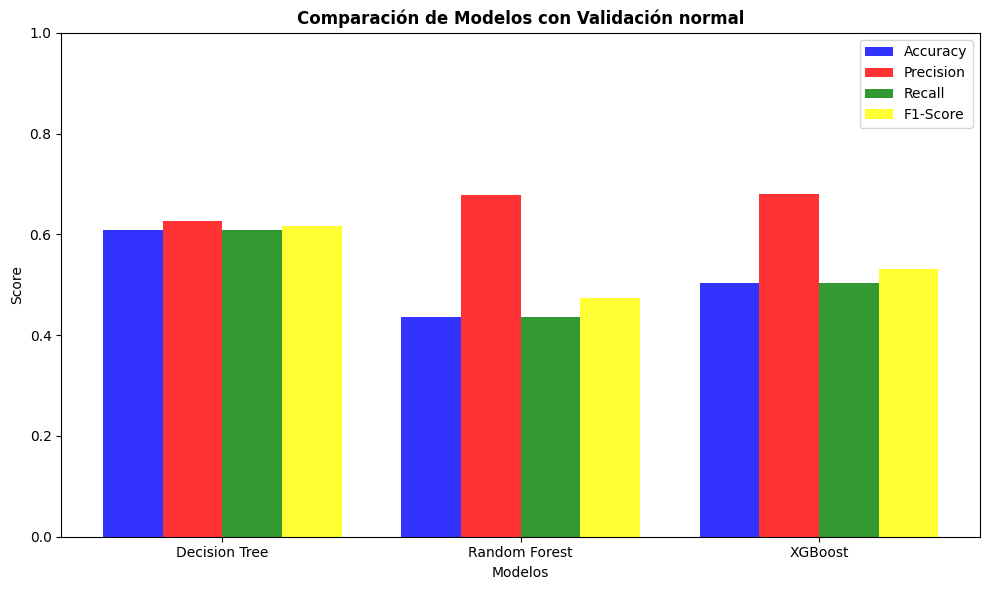

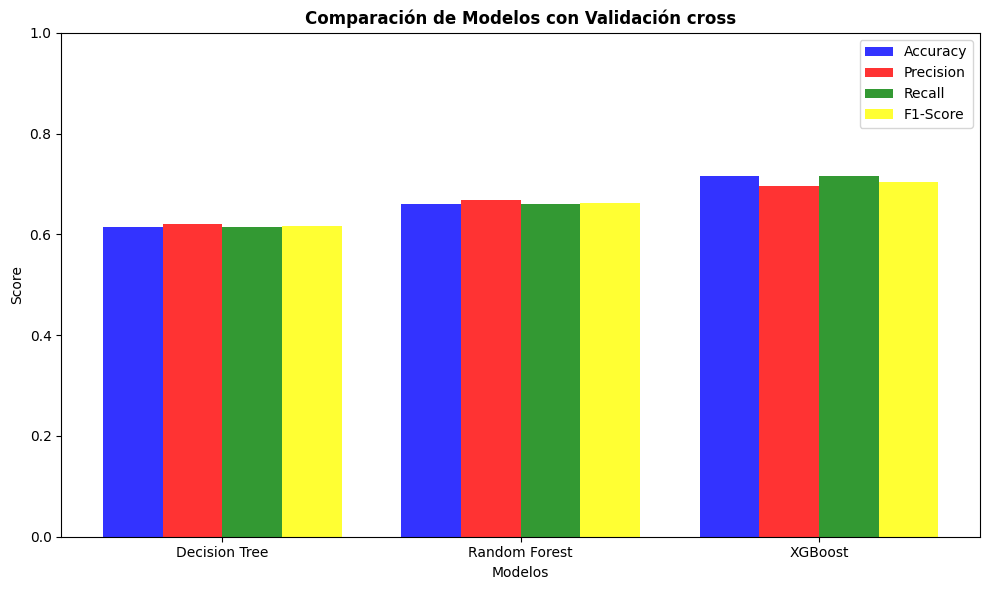

In [82]:
def comparacionResultado(results_df,label):
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    
    x = range(len(results_df))
    width = 0.2
    
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    colors = ['blue', 'red', 'green', 'yellow']
    
    for i, (metric, color) in enumerate(zip(metrics, colors)):
        ax.bar([p + width*i for p in x], results_df[metric],width, label=metric, color=color, alpha=0.8)

    ax.set_xlabel('Modelos')
    ax.set_ylabel('Score')
    ax.set_title(f'Comparación de Modelos con {label}', fontweight='bold')
    ax.set_xticks([p + width*1.5 for p in x])
    ax.set_xticklabels(results_df['Model'])
    ax.legend()
    ax.set_ylim(0, 1)
    plt.tight_layout()
    plt.show()

comparacionResultado(results_df,'Validación normal')
comparacionResultado(resultsCross_df,'Validación cross')

In [83]:
def compararEvaluaciones(results_normal, results_cv, criterio):
    results_normal = results_normal.copy()
    results_cv = results_cv.copy()
    results_normal['Evaluacion'] = 'Normal'
    results_cv['Evaluacion'] = 'CrossVal'
    mejor_normal = results_normal.loc[results_normal[criterio].idxmax()]
    mejor_cv = results_cv.loc[results_cv[criterio].idxmax()]
    
    if mejor_normal[criterio] >= mejor_cv[criterio]:
        return results_normal
    
    return results_cv

bestResult_df = compararEvaluaciones(results_df,resultsCross_df,'F1-Score')

## Análisis finales

### Análisis regional
Se utiliza el modelo que dió mejor resultado de los 3 que se probaron para aplicarlo dependiendo de la región de donde sea el estudiante, así se puede ver la cantidad de samples de estudiantes que se pueden sacar de cada región, también viendo como funciona el modelo en estos conjuntos separados por región y usando la métrica de F1-Score.

### Análisis a ciegas
Teniendo ya el modelo que mejores resultados dió en una validación normal, se hizo un análisis de estudiantes que no tienen información en el dataset de egresados de educación superior, pero que tienen toda la información disponible para predecir que podrían conseguir, se hace un análisis a ciegas para ver en que clasificarán estos estudiantes

In [84]:
def analisisRegional(models, df, results):
    regions = df['NOM_REG_RBD_A'].value_counts().index
    regional_results = []
    best_model_name = results.loc[results['F1-Score'].idxmax(), 'Model']
    best_model = trained_models[best_model_name]

    for region in regions:
        region_data = df[df['NOM_REG_RBD_A'] == region].copy()
        x_region = region_data.drop(columns=['nivel_carrera_2'])
        y_region = region_data['nivel_carrera_2']
        y_pred = best_model.predict(x_region)
        f1 = f1_score(y_region, y_pred, average='weighted', zero_division=0)
        regional_results.append({
                'Region': region,
                'Samples': len(region_data),
                'F1-Score': f1
            })     
        del region_data, x_region, y_region
        gc.collect()

    regional_df = pd.DataFrame(regional_results)
    regional_df = regional_df.sort_values(by='F1-Score', ascending=False)
    print(f"\nResultado regional ({best_model_name}):\n")
    print(regional_df.round(2))    

analisisRegional(trained_models, com_df, bestResult_df)


Resultado regional (XGBoost):

   Region  Samples  F1-Score
13    AYP     1244      0.72
3   MAULE     6352      0.67
14    MAG     1087      0.65
12   TPCA     1637      0.63
5    LGBO     5452      0.62
10   RIOS     1883      0.59
15  AYSEN      543      0.58
8   ANTOF     3484      0.58
11  ATCMA     1755      0.58
6     COQ     4600      0.54
2    BBIO    10003      0.53
1   VALPO    10403      0.53
9   NUBLE     3070      0.52
4   ARAUC     5677      0.52
7   LAGOS     4533      0.51
0      RM    39808      0.50


In [85]:
def analisisACiegas(models, df, clases,results):
    best_model_name = results.loc[results['F1-Score'].idxmax(), 'Model']
    best_model = models[best_model_name]

    y_pred = best_model.predict(df)
    conteo_predicciones = pd.Series(y_pred).value_counts().sort_index()

    conteo_completo = pd.Series(0, index=range(len(clases)))
    conteo_completo.update(conteo_predicciones)
    
    conteo_completo.index = [clases[i] for i in conteo_completo.index]

    print(f"\nResultado análisis a ciegas ({best_model_name}):\n")
    print(f"Total de registros: {len(med_df):,}")
    print(conteo_completo)

clases = ['Profesional','Tecnico','Postitulo','Magister','Doctorado']
analisisACiegas(trained_models, med_df,clases,bestResult_df)


Resultado análisis a ciegas (XGBoost):

Total de registros: 1,317,573
Profesional    873322
Tecnico        216125
Postitulo      123706
Magister       104420
Doctorado           0
dtype: int64
